<a href="https://colab.research.google.com/github/LucasBezerraSantos/Projetos_Pessoias/blob/master/Analise_de_credito_imobiliario.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Tipo de negócio:** Empresa Dream Housing Finance, a empresa lida com todos os empréstimos para habitação. Eles estão presentes em todas as áreas urbanas, semi-urbanas e rurais. O cliente aplica-se primeiro para um empréstimo à habitação depois que a empresa valida a elegibilidade do cliente para um empréstimo | Kaggle

**Problema:** A empresa deseja automatizar o processo de elegibilidade do empréstimo (em tempo real) com base nos detalhes do cliente fornecidos durante o preenchimento do formulário de inscrição on-line. Esses detalhes são sexo, estado civil, escolaridade, número de dependentes, renda, valor do empréstimo, histórico de crédito e outros. Para automatizar esse processo, eles criaram um problema para identificar os segmentos de clientes elegíveis para valores de empréstimo para atingir esses clientes especificamente.

## Análise exploratória e transformação de dados

### Bibliotécas e Leitura dos Dados

In [1]:
from google.colab import drive
drive.mount('drive_content')

Drive already mounted at drive_content; to attempt to forcibly remount, call drive.mount("drive_content", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
dados_imovel_train = pd.read_csv('/content/drive_content/MyDrive/Conjuntos_de_Dados/Kaggle/loan_sanction_train.csv')
dados_imovel_test = pd.read_csv('/content/drive_content/MyDrive/Conjuntos_de_Dados/Kaggle/loan_sanction_test.csv')

### Exploração de dados

In [4]:
dados_imovel_train.shape, dados_imovel_test.shape

((614, 13), (367, 12))

In [5]:
dados_imovel_train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


### Transformação de dados

In [6]:
colunas_renomeadas = { "No": 0, "Yes": 1, "Male": 0, "Female": 1, "N": 0, "Y": 1, "Not Graduate": 0, "Graduate": 1, '3+': 3 }

In [7]:
dados_train_convert = dados_imovel_train[[ 'Gender', 'Married', 'Education', 'Self_Employed', 'Dependents', 'Loan_Status' ]].replace(colunas_renomeadas)
dados_imovel_train[['Rural',	'Semiurban',	'Urban']] = pd.get_dummies(dados_imovel_train.Property_Area)
dados_imovel_train.drop([ 'Loan_ID', 'Gender', 'Married', 'Education', 'Self_Employed', 'Loan_Status', 'Property_Area', 'Dependents' ], axis=1, inplace=True)

In [8]:
dados_imovel_num = pd.concat([dados_imovel_train, dados_train_convert], axis=1)

In [9]:
dados_imovel_num.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Rural,Semiurban,Urban,Gender,Married,Education,Self_Employed,Dependents,Loan_Status
0,5849,0.0,NaN,360.0,1.0,0,0,1,0.0,0.0,1,0.0,0,1
1,4583,1508.0,128.0,360.0,1.0,1,0,0,0.0,1.0,1,0.0,1,0
2,3000,0.0,66.0,360.0,1.0,0,0,1,0.0,1.0,1,1.0,0,1
3,2583,2358.0,120.0,360.0,1.0,0,0,1,0.0,1.0,0,0.0,0,1
4,6000,0.0,141.0,360.0,1.0,0,0,1,0.0,0.0,1,0.0,0,1


### Tratamento de dados nulos

In [10]:
dados_imovel_num.isnull().sum()

ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Rural                 0
Semiurban             0
Urban                 0
Gender               13
Married               3
Education             0
Self_Employed        32
Dependents           15
Loan_Status           0
dtype: int64

**Dados em menor quantidade serão apagados**

In [11]:
drop_married = dados_imovel_num.loc[dados_imovel_num['Married'].isnull() == True]
dados_imovel_num.drop(drop_married.index, axis=0, inplace=True)

**As colunas que possuem dados vazios representam 0 e 1, "não" ou "sim", são dados categóricos e não contínuos. Por esse motivo é mais eficiênte usar a moda para preencher os dados nulos, com os dados que tem mais probalidade de ocorrer.**

In [12]:
for indice in range(len(dados_imovel_num.columns)):
  moda = int(dados_imovel_num[dados_imovel_num.columns[indice]].mode())
  dados_imovel_num[dados_imovel_num.columns[indice]] = dados_imovel_num[dados_imovel_num.columns[indice]].fillna(moda)

In [13]:
dados_imovel_num.isna().sum()

ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Rural                0
Semiurban            0
Urban                0
Gender               0
Married              0
Education            0
Self_Employed        0
Dependents           0
Loan_Status          0
dtype: int64

**Alterando dados float para int antes de usar a técnica de balanceamento SMOTE**

In [14]:
dados_imovel_num = dados_imovel_num.astype(int)
dados_imovel_num.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 611 entries, 0 to 613
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   ApplicantIncome    611 non-null    int64
 1   CoapplicantIncome  611 non-null    int64
 2   LoanAmount         611 non-null    int64
 3   Loan_Amount_Term   611 non-null    int64
 4   Credit_History     611 non-null    int64
 5   Rural              611 non-null    int64
 6   Semiurban          611 non-null    int64
 7   Urban              611 non-null    int64
 8   Gender             611 non-null    int64
 9   Married            611 non-null    int64
 10  Education          611 non-null    int64
 11  Self_Employed      611 non-null    int64
 12  Dependents         611 non-null    int64
 13  Loan_Status        611 non-null    int64
dtypes: int64(14)
memory usage: 71.6 KB


### Balanceamento e Normalização

O balanceamento de dados é importante porque ajuda a evitar problemas de desequilíbrio de dados que podem afetar negativamente a precisão do algoritmo de Machine Learning. Portanto, é uma boa prática equilibrar os dados antes de rodar o algoritmo | ChatGPT

In [15]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [16]:
SEED = 3192
np.random.seed(SEED)

smote = SMOTE()
scaler = StandardScaler()

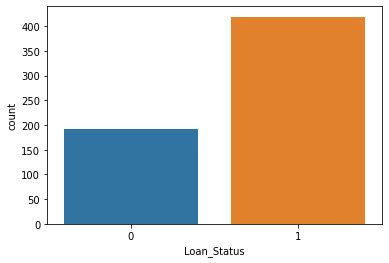

In [17]:
ax = sns.countplot(x='Loan_Status', data=dados_imovel_num)

In [18]:
X = dados_imovel_num.drop('Loan_Status', axis=1)
y = dados_imovel_num['Loan_Status']

X, y = smote.fit_resample(X, y)

In [19]:
dados_imovel_final = pd.concat([X, y], axis=1)

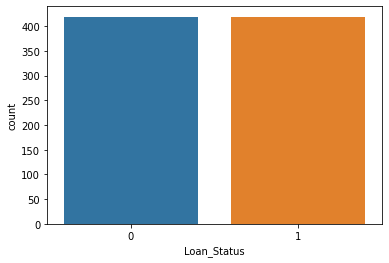

In [20]:
ax = sns.countplot(x= 'Loan_Status', data= dados_imovel_final)

In [21]:
dados_imovel_final.shape

(838, 14)

**Normalização**

In [22]:
X_normalizado = scaler.fit_transform(X)

## Aplicação do Modelo

In [23]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier 
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

In [24]:
X_train, X_test, y_train, y_test = train_test_split( X_normalizado, y, test_size=0.30, random_state= SEED, stratify= y )

### DummyClassifier

In [25]:
dummy = DummyClassifier()
dummy.fit(X_train, y_train)
acuracia = dummy.score(X_test, y_test) * 100

print('A acurácia do Dummy foi de %d%%' % acuracia)

A acurácia do Dummy foi de 50%


### KNN

In [26]:
model_knn = KNeighborsClassifier(metric= 'euclidean')

model_knn.fit(X_train, y_train)
previsao_knn = model_knn.predict(X_test)

In [27]:
print('A Acurácia do KNN foi de %d%% \n' % (accuracy_score(y_test, previsao_knn)*100))
print('A Precisao do KNN foi de %d%% \n' % (precision_score(y_test, previsao_knn)*100))
print('O Reccal_score do KNN foi de %d%% \n' % (recall_score(y_test, previsao_knn)*100))
print('O F1-Score do KNN foi de %d%%' % (f1_score(y_test, previsao_knn)*100))

A Acurácia do KNN foi de 80% 

A Precisao do KNN foi de 74% 

O Reccal_score do KNN foi de 94% 

O F1-Score do KNN foi de 83%


**Matriz de confusão**

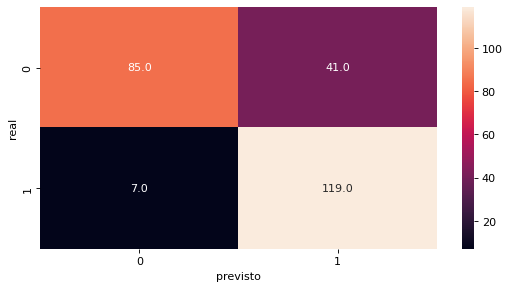

In [28]:
set()
plt.figure(figsize=(8,4), dpi=80)
sns.heatmap(confusion_matrix(y_test, previsao_knn), annot=True, fmt='.1f').set(xlabel = 'previsto', ylabel= 'real')
plt.show()

### Bernoulli

In [29]:
model_bnb = BernoulliNB(binarize= np.median(X_train))

model_bnb.fit(X_train, y_train)
previsao_bnb = model_bnb.predict(X_test)

In [30]:
print('A Acurácia do Bernoulli foi de %d%% \n' % (accuracy_score(y_test, previsao_bnb)*100))
print('A Precisao do Bernoulli foi de %d%% \n' % (precision_score(y_test, previsao_bnb)*100))
print('O Reccal_score do Bernoulli foi de %d%% \n' % (recall_score(y_test, previsao_bnb)*100))
print('O F1-Score do Bernoulli foi de %d%%' % (f1_score(y_test, previsao_bnb)*100))

A Acurácia do Bernoulli foi de 80% 

A Precisao do Bernoulli foi de 73% 

O Reccal_score do Bernoulli foi de 93% 

O F1-Score do Bernoulli foi de 82%


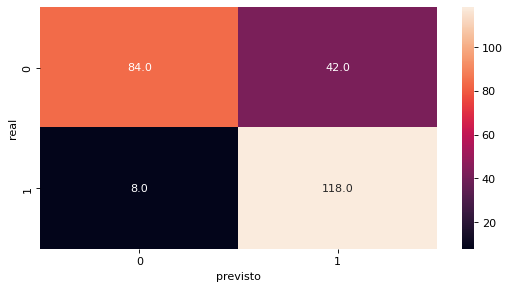

In [31]:
set()
plt.figure(figsize=(8,4), dpi=80)
sns.heatmap(confusion_matrix(y_test, previsao_bnb), annot=True, fmt='.1f').set(xlabel = 'previsto', ylabel= 'real')
plt.show()

### RandomForest

In [32]:
model_random = RandomForestClassifier( criterion= 'entropy', n_estimators=100, random_state=SEED )

model_random.fit(X_train, y_train)
previsao_random = model_random.predict(X_test)

In [33]:
print('A Acurácia do RandomForest foi de %d%% \n' % (accuracy_score(y_test, previsao_random)*100))
print('A Precisao do RandomForest foi de %d%% \n' % (precision_score(y_test, previsao_random)*100))
print('O Reccal_score do RandomForest foi de %d%% \n' % (recall_score(y_test, previsao_random)*100))
print('O F1-Score do RandomForest foi de %d%%' % (f1_score(y_test, previsao_random)*100))

A Acurácia do RandomForest foi de 84% 

A Precisao do RandomForest foi de 80% 

O Reccal_score do RandomForest foi de 92% 

O F1-Score do RandomForest foi de 85%


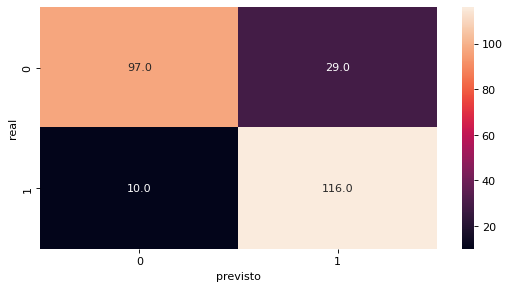

In [34]:
set()
plt.figure(figsize=(8,4), dpi=80)
sns.heatmap(confusion_matrix(y_test, previsao_random), annot=True, fmt='.1f').set(xlabel = 'previsto', ylabel= 'real')
plt.show()

### SVC

In [35]:
model_svc = SVC()

model_svc.fit(X_train, y_train)
previsao_svc = model_svc.predict(X_test)

In [36]:
print('A Acurácia do RandomForest foi de %d%% \n' % (accuracy_score(y_test, previsao_svc)*100))
print('A Precisao do RandomForest foi de %d%% \n' % (precision_score(y_test, previsao_svc)*100))
print('O Reccal_score do RandomForest foi de %d%% \n' % (recall_score(y_test, previsao_svc)*100))
print('O F1-Score do RandomForest foi de %d%%' % (f1_score(y_test, previsao_svc)*100))

A Acurácia do RandomForest foi de 84% 

A Precisao do RandomForest foi de 76% 

O Reccal_score do RandomForest foi de 99% 

O F1-Score do RandomForest foi de 86%


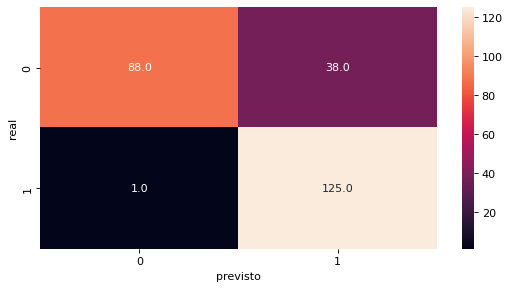

In [37]:
set()
plt.figure(figsize=(8,4), dpi=80)
sns.heatmap(confusion_matrix(y_test, previsao_svc), annot=True, fmt='.1f').set(xlabel = 'previsto', ylabel= 'real')
plt.show()

## Aplicação com PCA

PCA (Principal Component Analysis) é uma técnica de redução de dimensionalidade que permite identificar os padrões subjacentes nos dados, removendo as correlações entre as variáveis e criando um conjunto menor de variáveis chamadas de componentes principais. A técnica funciona identificando os eixos que melhor explicam a variabilidade nos dados. | Chat GPT. 

O objetivo desta aplicação é reduzir a dimencionalidade e verificar se os modelos obtém melhores resultados. 

In [38]:
from sklearn.decomposition import PCA

In [39]:
pca = PCA( n_components = 10)
X_pca = pca.fit_transform(X_normalizado)

X_train, X_test, y_train, y_test = train_test_split( X_pca, y, test_size=0.30, random_state= SEED, stratify= y )

### KNN - PCA

In [40]:
model_knn = KNeighborsClassifier(metric= 'euclidean')

model_knn.fit(X_train, y_train)
previsao_knn = model_knn.predict(X_test)

In [41]:
print('A Acurácia do KNN foi de %d%% \n' % (accuracy_score(y_test, previsao_knn)*100))
print('A Precisao do KNN foi de %d%% \n' % (precision_score(y_test, previsao_knn)*100))
print('O Reccal_score do KNN foi de %d%% \n' % (recall_score(y_test, previsao_knn)*100))
print('O F1-Score do KNN foi de %d%%' % (f1_score(y_test, previsao_knn)*100))

A Acurácia do KNN foi de 81% 

A Precisao do KNN foi de 76% 

O Reccal_score do KNN foi de 92% 

O F1-Score do KNN foi de 83%


**Matriz de confusão**

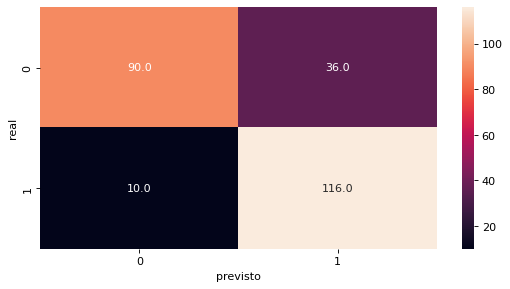

In [42]:
set()
plt.figure(figsize=(8,4), dpi=80)
sns.heatmap(confusion_matrix(y_test, previsao_knn), annot=True, fmt='.1f').set(xlabel = 'previsto', ylabel= 'real')
plt.show()

### Bernoulli - PCA

In [43]:
model_bnb = BernoulliNB(binarize= np.median(X_train))

model_bnb.fit(X_train, y_train)
previsao_bnb = model_bnb.predict(X_test)

In [44]:
print('A Acurácia do Bernoulli foi de %d%% \n' % (accuracy_score(y_test, previsao_bnb)*100))
print('A Precisao do Bernoulli foi de %d%% \n' % (precision_score(y_test, previsao_bnb)*100))
print('O Reccal_score do Bernoulli foi de %d%% \n' % (recall_score(y_test, previsao_bnb)*100))
print('O F1-Score do Bernoulli foi de %d%%' % (f1_score(y_test, previsao_bnb)*100))

A Acurácia do Bernoulli foi de 77% 

A Precisao do Bernoulli foi de 71% 

O Reccal_score do Bernoulli foi de 92% 

O F1-Score do Bernoulli foi de 80%


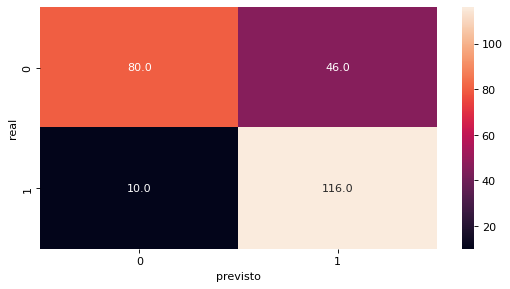

In [45]:
set()
plt.figure(figsize=(8,4), dpi=80)
sns.heatmap(confusion_matrix(y_test, previsao_bnb), annot=True, fmt='.1f').set(xlabel = 'previsto', ylabel= 'real')
plt.show()

### RandomForest - PCA

In [46]:
model_random = RandomForestClassifier( criterion= 'entropy', n_estimators=120, random_state=SEED )

model_random.fit(X_train, y_train)
previsao_random = model_random.predict(X_test)

In [47]:
print('A Acurácia do RandomForest foi de %d%% \n' % (accuracy_score(y_test, previsao_random)*100))
print('A Precisao do RandomForest foi de %d%% \n' % (precision_score(y_test, previsao_random)*100))
print('O Reccal_score do RandomForest foi de %d%% \n' % (recall_score(y_test, previsao_random)*100))
print('O F1-Score do RandomForest foi de %d%%' % (f1_score(y_test, previsao_random)*100))

A Acurácia do RandomForest foi de 83% 

A Precisao do RandomForest foi de 79% 

O Reccal_score do RandomForest foi de 90% 

O F1-Score do RandomForest foi de 84%


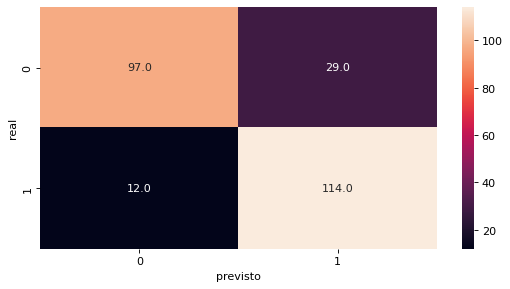

In [48]:
set()
plt.figure(figsize=(8,4), dpi=80)
sns.heatmap(confusion_matrix(y_test, previsao_random), annot=True, fmt='.1f').set(xlabel = 'previsto', ylabel= 'real')
plt.show()

### SVC - PCA

In [49]:
model_svc = SVC()

model_svc.fit(X_train, y_train)
previsao_svc = model_svc.predict(X_test)

In [50]:
print('A Acurácia do RandomForest foi de %d%% \n' % (accuracy_score(y_test, previsao_svc)*100))
print('A Precisao do RandomForest foi de %d%% \n' % (precision_score(y_test, previsao_svc)*100))
print('O Reccal_score do RandomForest foi de %d%% \n' % (recall_score(y_test, previsao_svc)*100))
print('O F1-Score do RandomForest foi de %d%%' % (f1_score(y_test, previsao_svc)*100))

A Acurácia do RandomForest foi de 84% 

A Precisao do RandomForest foi de 76% 

O Reccal_score do RandomForest foi de 99% 

O F1-Score do RandomForest foi de 86%


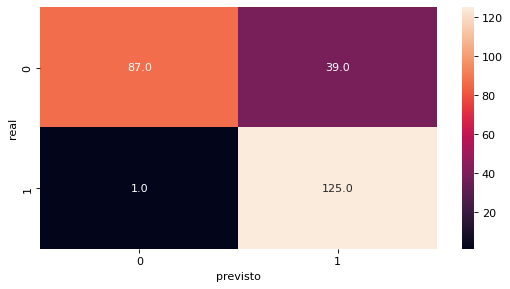

In [51]:
set()
plt.figure(figsize=(8,4), dpi=80)
sns.heatmap(confusion_matrix(y_test, previsao_svc), annot=True, fmt='.1f').set(xlabel = 'previsto', ylabel= 'real')
plt.show()

## Comentários

Foram utilizados 4 modelos de classificação, entre eles o RandomForest obteve as melhores métricas. Um dos motivos é que o RandomForest não sensível a outliers e por esse motivo conseguiu ter bom balanceamento dos dados para realizar a classificação. 

Foi utilizado o PCA como técnica para diminuir as dimensões dos dados e avaliar se o algoritmo gerava melhores métricas. O PCA contribuir para maior velocidade no processamento e seleção de variáveis com baixa correlação. No entanto, por se tratar de um conjunto de dados pequeno, a redução de dimencionalidade impactou negativamente as métricas e o trainamento com o dataset completo permaneceu sendo o melhor. 

Esse que desenvolvemos irá retornar a classificação de clientes aptos ou inaptos para obtenção de crédito, por esse motivo, as métricas mais relevantes são a Acurácia e a Precisão. A primeira mede o nível geral de acerto nas classificações e o segundo na definição dos clientes aptos a receber o crédito. 

Caso tenhamos muitos "falsos positivos", o algoritmo concederá crédito a clientes inaptos, o que pode gerar perda de dinheiro devido ao alto risco. E quando o algoritmo tiver muitos falsos negativos, pode perder boas oportunidades de gerar crédito para bons pagadores. Por esse motivo o ideal é manter os dois níveis baixos.

Por essas razões, é recomendado o uso do RandomForest Classifier para inicio dos testes na empresa ( Acurácia 84% | Precisao 80% )